<a href="https://colab.research.google.com/github/cihanozluk/textsummarizationturkish/blob/main/Extraction_Based_Text_Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

Reference

https://medium.com/kaveai/türkçe-metinlerde-özetleme-f6daf4f570f9

In [ ]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import heapq
from gensim.summarization.summarizer import summarize
from gensim.summarization import keywords
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
%matplotlib inline
from gensim.models import KeyedVectors
import networkx as nx
from nltk.translate.bleu_score import sentence_bleu


## MLSUM Dataset


In [ ]:
!pip install datasets
from datasets import load_dataset
dataset = load_dataset(
   'mlsum', 'tu')




df = pd.DataFrame(dataset['train'], columns=dataset['train'].features)

all_news = df.head()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 4.2 MB/s 
     |████████████████████████████████| 212 kB 66.4 MB/s 
     |████████████████████████████████| 132 kB 46.6 MB/s 
     |████████████████████████████████| 182 kB 55.5 MB/s 
     |████████████████████████████████| 127 kB 77.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


Generating train split:   0%|          | 0/249277 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11565 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12775 [00:00<?, ? examples/s]

Dataset mlsum downloaded and prepared to /root/.cache/huggingface/datasets/mlsum/tu/1.0.0/033c69bbbf1eb198d444f668be75f297cb86251c0671a3d063d1c53c2f231076. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
all_news

,text,summary,topic,url,title,date
0,Araç sahipleri için pahalı benzine karşı yapıl...,Benzinin litresi 4 liraya yaklaştı. Aslında ar...,unknown,https://www.internethaber.com/aracinizda-yuzde...,Aracınızda yüzde 30 tarassuf edin,00/01/2010
1,"İki insanın kaderini birleştiren olay, Adana S...","Seyhan Nehri""ne düştüğünü gören genç öğretmen,...",unknown,https://www.internethaber.com/kahraman-ogretme...,Kahraman öğretmen hayat kurtardı,00/01/2010
2,Meksika'nın kuzey sınırında bir grup silahlı k...,Meksika'da parti düzenlenen bir eve yapılan sa...,unknown,https://www.internethaber.com/parti-yapanlari-...,Parti yapanları taradılar: 13 ölü,00/01/2010
3,"Fenerbahçe Teknik Direktörü Christoph Daum, Si...","Fenerbahçe Teknik Direktörü Christoph Daum, Si...",unknown,https://www.internethaber.com/daum-oynanan-oyu...,Daum oynanan oyundan memnun,00/01/2010
4,İslam Konferansı Teşkilatı (İKT) Daimi Konsey ...,İslam Konferansı'nda 57 ülkenin temsilcisi İsv...,unknown,https://www.internethaber.com/islam-konferansi...,İslam Konferansında minare tepkisi,00/01/2010


In [ ]:
import nltk
nltk.download('punkt')
all_news['Tokenized_Text'] = all_news['text'].apply(word_tokenize)
all_news['Tokenized_Sentence'] = all_news['text'].apply(sent_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-8-61fb6eb71d28>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_news['Tokenized_Text'] = all_news['text'].apply(word_tokenize)
<ipython-input-8-61fb6eb71d28>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_news['Tokenized_Sentence'] = all_news['text'].apply(sent_tokenize)


In [ ]:
nltk.download('stopwords')

stop_words = stopwords.words('turkish')
stop_words.append("bir")
corpus = []
for news in all_news['Tokenized_Text']:
    temp_list = []
    for word in news:
        if ((word.lower() not in stop_words) and (len(word) > 2)):
            temp_list.append(word)
    corpus.append(temp_list[:-22])    

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.




```
# This is formatted as code
```

## Text Imaginary

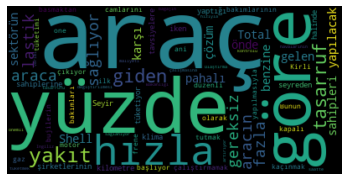

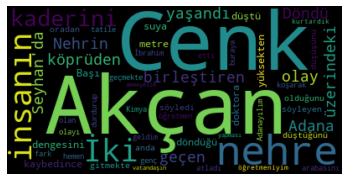

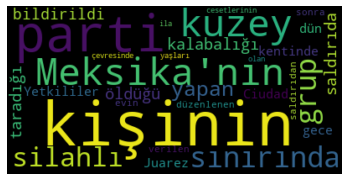

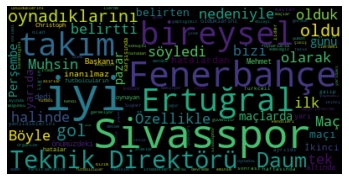

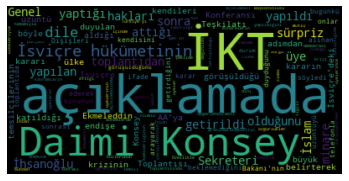

In [ ]:
for i in range(5):
    cloud_for_text = WordCloud().generate(' '.join(corpus[i]))
    plt.imshow(cloud_for_text, interpolation="bilinear")
    plt.axis("off")
    plt.show()


In [ ]:
def summarize_func(words,sentences):
    word2count = {}
    for word in words:
        if word.lower() not in word2count.keys():
            word2count[word.lower()] = 1
        else:
            word2count[word.lower()] += 1
        
    maxi = max(word2count.values())
    
    for key in word2count.keys():
        word2count[key] = word2count[key]/maxi
        
    sent2score = {}
    for sentence in sentences:
        for word in word_tokenize(sentence.lower()):
            if word in word2count.keys():
                if len(sentence.split(' ')) < 15:
                    if sentence not in sent2score.keys():
                        sent2score[sentence] = word2count[word]
                    else:
                        sent2score[sentence] += word2count[word]
                        
    best_sentences = heapq.nlargest(5, sent2score, key=sent2score.get)
    return best_sentences

In [ ]:
all_news['Summarized_Text'] = ""
for i in range(all_news.shape[0]):
    all_news['Summarized_Text'][i] = summarize_func(all_news['Tokenized_Text'][i],all_news['Tokenized_Sentence'][i])

<ipython-input-19-a823ff2b5e68>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_news['Summarized_Text'] = ""
<ipython-input-19-a823ff2b5e68>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_news['Summarized_Text'][i] = summarize_func(all_news['Tokenized_Text'][i],all_news['Tokenized_Sentence'][i])


In [ ]:
all_news.head()

,text,summary,topic,url,title,date,Tokenized_Text,Tokenized_Sentence,Summarized_Text
0,Araç sahipleri için pahalı benzine karşı yapıl...,Benzinin litresi 4 liraya yaklaştı. Aslında ar...,unknown,https://www.internethaber.com/aracinizda-yuzde...,Aracınızda yüzde 30 tarassuf edin,00/01/2010,"[Araç, sahipleri, için, pahalı, benzine, karşı...",[Araç sahipleri için pahalı benzine karşı yapı...,"[Daha az yakıt tüketimi, ilk olarak araç bakım..."
1,"İki insanın kaderini birleştiren olay, Adana S...","Seyhan Nehri""ne düştüğünü gören genç öğretmen,...",unknown,https://www.internethaber.com/kahraman-ogretme...,Kahraman öğretmen hayat kurtardı,00/01/2010,"[İki, insanın, kaderini, birleştiren, olay, ,,...","[İki insanın kaderini birleştiren olay, Adana ...","[Zaten havuza yüzmeye gidiyordum, kısmet nehir..."
2,Meksika'nın kuzey sınırında bir grup silahlı k...,Meksika'da parti düzenlenen bir eve yapılan sa...,unknown,https://www.internethaber.com/parti-yapanlari-...,Parti yapanları taradılar: 13 ölü,00/01/2010,"[Meksika'nın, kuzey, sınırında, bir, grup, sil...",[Meksika'nın kuzey sınırında bir grup silahlı ...,[Saldırıda yaralanan 20'den fazla gencin de am...
3,"Fenerbahçe Teknik Direktörü Christoph Daum, Si...","Fenerbahçe Teknik Direktörü Christoph Daum, Si...",unknown,https://www.internethaber.com/daum-oynanan-oyu...,Daum oynanan oyundan memnun,00/01/2010,"[Fenerbahçe, Teknik, Direktörü, Christoph, Dau...","[Fenerbahçe Teknik Direktörü Christoph Daum, S...",[Maç sonrası bir değerlendirme yapan Fenerbahç...
4,İslam Konferansı Teşkilatı (İKT) Daimi Konsey ...,İslam Konferansı'nda 57 ülkenin temsilcisi İsv...,unknown,https://www.internethaber.com/islam-konferansi...,İslam Konferansında minare tepkisi,00/01/2010,"[İslam, Konferansı, Teşkilatı, (, İKT, ), Daim...",[İslam Konferansı Teşkilatı (İKT) Daimi Konsey...,"[Açıklamada, minarelerin İslam kültürünün bir ..."


*italicized text*## Word Frequency Algorythm
 

In [ ]:
def calculate_bleu(generated_summary, reference_summaries):
  
  # Convert the summary and reference summaries to lists of sentences
  generated_sentences = generated_summary
  print(generated_sentences)
  
  reference_sentences = reference_summaries
  print(reference_sentences)
  
  # Calculate the BLEU score
  print('Individual 1-gram: %f' % sentence_bleu(reference_sentences, generated_sentences, weights=(1, 0, 0, 0)))
  print('Individual 2-gram: %f' % sentence_bleu(reference_sentences, generated_sentences, weights=(0, 1, 0, 0)))
  print('Individual 3-gram: %f' % sentence_bleu(reference_sentences, generated_sentences, weights=(0, 0, 1, 0)))
  print('Individual 4-gram: %f' % sentence_bleu(reference_sentences, generated_sentences, weights=(0, 0, 0, 1)))

  score = sentence_bleu(reference_sentences, generated_sentences, weights=(1, 0, 0, 0))
  print(score)

  return score

In [ ]:
for i in range(all_news.shape[0]):
    print("{:.2f}".format(calculate_bleu(str(all_news['Summarized_Text'][i]),str(all_news['summary'][i]))))

['Daha az yakıt tüketimi, ilk olarak araç bakımlarının düzenli yapılmasıyla başlıyor.', 'Klimanın çalıştırılması, yakıt tüketimini yüzde 8 artırıyor.', 'Gereksiz bagajın maliyeti yüzde 5 daha fazla yakıt tüketmek.', 'Lastik havalarının kontrolü, verimi yüzde 3 artırıyor.', 'Araç sahipleri için pahalı benzine karşı yapılacak çözüm; tasarruf.']
Benzinin litresi 4 liraya yaklaştı. Aslında aracınızda çok küçük bir dikkatle akaryakıtta yüzde 30 kar edebilirsiniz.
Individual 1-gram: 0.066860
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000


/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

0.06686046511627905
0.07
['Zaten havuza yüzmeye gidiyordum, kısmet nehirde yüzmekmiş, oraya atladık” diyerek anlattı.', 'Nehrin üzerindeki köprüden geçen Döndü Akçan, dengesini kaybedince 10 metre yüksekten suya düştü.', 'Cenk olayı, “Adanayılım, tatile geldim buraya.', 'Kimya öğretmeniyim, can kurtardık demeyelim de her vatandaşın yapması gereken görevi yaptım.', 'Akçan’ın nehre düşüşünü oradan geçmekte olan genç öğretmen İbrahim Cenk fark etti.']
Seyhan Nehri"ne düştüğünü gören genç öğretmen, hemen nehre atlayıp hasta kadını kurtardı.
Individual 1-gram: 0.060890
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
0.06088992974238875
0.06
["Saldırıda yaralanan 20'den fazla gencin de ambulanslarla hastaneye kaldırıldıkları belirtildi.", 'Görgü tanıkları, saldırganların en az 15 kişi olduğunu belirtti', 'Yaralıların durumlarının netlik kazanmadığı kaydedildi.']
Meksika'da parti düzenlenen bir eve yapılan saldırıda ilk belirlemelere göre 13 kişi yaşamını y